In [106]:
#We start by importing all necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import datetime
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet
import logging

%matplotlib inline

In [2]:
#Loading the dataset from the same folder that contains this notebook
df = []
for j in range(0,112):
    df.append(pd.read_csv("/Users/user/Documents/Stutern Task_files/Final_Power_Project/Project_Submission_Ayooluwa/smart_meters_data/block_"+str(j)+".csv"))
    
#all data from blocks are first loaded into a list then concatenated into a dataframe
    
energy = pd.concat(df, ignore_index = True)
energy.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000002,2012-10-12,0.1385,0.154304,0.886,46,0.196034,7.098,0.000
1,MAC000002,2012-10-13,0.1800,0.230979,0.933,48,0.192329,11.087,0.076
2,MAC000002,2012-10-14,0.1580,0.275479,1.085,48,0.274647,13.223,0.070
3,MAC000002,2012-10-15,0.1310,0.213688,1.164,48,0.224483,10.257,0.070
4,MAC000002,2012-10-16,0.1450,0.203521,0.991,48,0.184115,9.769,0.087


# Feature Engineering and Exploratory Data Analysis

Each row of data in the energy dataset contains electricity data about individual houses. The LCLid column is a unique house number while the day column contains a time stamp for each day during which data was collected

In [3]:
energy = energy[['LCLid', 'day', 'energy_sum']] #pick out the important part of the data for each house

In [4]:
energy.day = pd.to_datetime(energy.day, format = '%Y-%m-%d').dt.date #Convert the time series data to datetime format for ease of working with time series data

In [6]:
###Aggregation based on time
energy_by_day = energy.groupby('day')[['energy_sum']].sum()#onvert to time series by aggregating the energy sum for each day for different houses

###The energy sum can be misleading based on difference in number of smart meters deployed over time. The mean energy per day will be a better representation of data
energy_count = energy.groupby('day')[['LCLid']].nunique() #find the number of houses per day
energy_by_day = energy_by_day.merge(energy_count, on = ['day'])#merge the number of houses with the energy data frame
energy_by_day['energy_mean'] = energy_by_day['energy_sum']/energy_by_day['LCLid'] #create a new average column
energy_by_day.head()

,energy_sum,LCLid,energy_mean
day,,,
2011-11-23,90.385000,13,6.952692
2011-11-24,213.412000,25,8.536480
2011-11-25,303.993000,32,9.499781
2011-11-26,420.976000,41,10.267707
2011-11-27,444.883001,41,10.850805


In [19]:
# Explore Location Properties
energy_by_location = energy.groupby('LCLid')[['energy_sum']].sum() #aggregate energy based on location
energy_by_location.head()


,energy_sum
LCLid,
MAC000002,6095.672001
MAC000003,14080.862003
MAC000004,1119.839000
MAC000005,2911.006000
MAC000006,2167.448000


In [20]:
###Using Kmeans clustering, we can try to cluster the data based on energy consumption in the absence of the Acorn data classifying customers into affluent, comfortable and adversity
###This approach is useful in a place like Nigeria where data about customer income may not be provided to Electricity Distribution Companies
kmeans = KMeans(n_clusters = 3, max_iter = 600, algorithm = 'auto')
kmeans.fit(energy_by_location)
energy_by_location['location_cluster'] = kmeans.labels_
energy_by_location.head()

,energy_sum,location_cluster
LCLid,,
MAC000002,6095.672001,0
MAC000003,14080.862003,1
MAC000004,1119.839000,0
MAC000005,2911.006000,0
MAC000006,2167.448000,0


In [21]:
#import the acorn classification dataset which classifies energy usage based on location

acorn = pd.read_csv("/Users/user/Documents/Stutern Task_files/Final_Power_Project/Project_Submission_Ayooluwa/smart_meters_data/informations_households.csv")
acorn

#Under the acorn_grouped classificattion which segments customers based on income, there should be only three categories- Affluent, Comfortable, and Adversity. 
#The code below removes possible errors (ACORN AND ACORN U)that don't belong to those categories
wrong_list = []
for j in range(len(acorn)):
    if acorn.iloc[j, 2] == 'ACORN-':
        wrong_list.append(j)
    elif acorn.iloc[j, 2] == 'ACORN-U':
        wrong_list.append(j)
        
acorn.drop(wrong_list, axis = 0, inplace = True)
acorn['Acorn_grouped'].unique()

array(['Affluent', 'Comfortable', 'Adversity'], dtype=object)

In [22]:
#merge the energy by location and acorn datasets

energy_acorn = pd.merge(energy_by_location, acorn, on = 'LCLid', how = 'inner')
energy_acorn

,LCLid,energy_sum,location_cluster,stdorToU,Acorn,Acorn_grouped,file
0,MAC000002,6095.672001,0,Std,ACORN-A,Affluent,block_0
1,MAC000003,14080.862003,1,Std,ACORN-P,Adversity,block_91
2,MAC000004,1119.839000,0,Std,ACORN-E,Affluent,block_39
3,MAC000005,2911.006000,0,ToU,ACORN-C,Affluent,block_5
4,MAC000006,2167.448000,0,Std,ACORN-Q,Adversity,block_95
...,...,...,...,...,...,...,...
5510,MAC005563,0.000000,0,Std,ACORN-Q,Adversity,block_109
5511,MAC005564,2314.168999,0,ToU,ACORN-Q,Adversity,block_103
5512,MAC005565,5.790000,0,ToU,ACORN-C,Affluent,block_6
5513,MAC005566,8942.237999,1,Std,ACORN-E,Affluent,block_19


# Visualization based on location#

In [23]:

energy_acorn_time = pd.merge(energy, acorn, on = 'LCLid', how = 'inner')#merge the general energy dataframe with the acorn df
energy_acorn_time.head()

,LCLid,day,energy_sum,stdorToU,Acorn,Acorn_grouped,file
0,MAC000002,2012-10-12,7.098,Std,ACORN-A,Affluent,block_0
1,MAC000002,2012-10-13,11.087,Std,ACORN-A,Affluent,block_0
2,MAC000002,2012-10-14,13.223,Std,ACORN-A,Affluent,block_0
3,MAC000002,2012-10-15,10.257,Std,ACORN-A,Affluent,block_0
4,MAC000002,2012-10-16,9.769,Std,ACORN-A,Affluent,block_0


In [24]:
##Merge the location clusters with the main energy_acorn_time dataset as well
energy_by_location = energy_by_location.reset_index()
to_be_merged = energy_by_location[['LCLid', 'location_cluster']]
to_be_merged
energy_acorn_time = pd.merge(energy_acorn_time, to_be_merged, on = 'LCLid', how = 'left')
energy_acorn_time
energy_acorn_time.head()

,LCLid,day,energy_sum,stdorToU,Acorn,Acorn_grouped,file,location_cluster
0,MAC000002,2012-10-12,7.098,Std,ACORN-A,Affluent,block_0,0
1,MAC000002,2012-10-13,11.087,Std,ACORN-A,Affluent,block_0,0
2,MAC000002,2012-10-14,13.223,Std,ACORN-A,Affluent,block_0,0
3,MAC000002,2012-10-15,10.257,Std,ACORN-A,Affluent,block_0,0
4,MAC000002,2012-10-16,9.769,Std,ACORN-A,Affluent,block_0,0


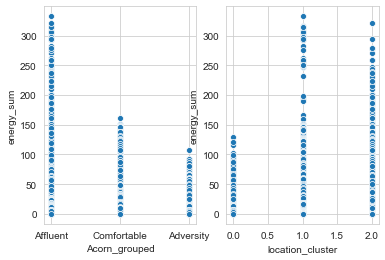

In [25]:
#Make a scatter plot comparing acorn classification with location clustering
plt.subplot(1,2,1)
sns.set_style('whitegrid')
figsize = (30,5)
sns.scatterplot(data = energy_acorn_time, x = 'Acorn_grouped', y = 'energy_sum', sizes = "coherence")

plt.subplot(1,2,2)
sns.set_style('whitegrid')
figsize = (30,5)
sns.scatterplot(data = energy_acorn_time, x = 'location_cluster', y = 'energy_sum', sizes = "coherence")

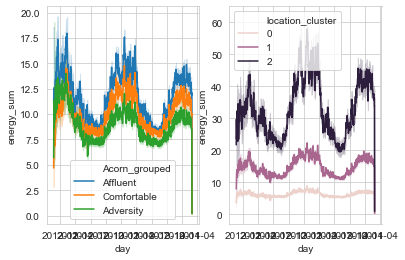

In [27]:
plt.subplot(1,2,1)
sns.set_style('whitegrid')
figsize = (30,5)
sns.lineplot(data = energy_acorn_time, x = 'day', y = 'energy_sum', hue = 'Acorn_grouped', sizes = "coherence")

plt.subplot(1,2,2)
sns.set_style('whitegrid')
figsize = (30,5)
sns.lineplot(data = energy_acorn_time, x = 'day', y = 'energy_sum', hue = 'location_cluster', sizes = "coherence")


While the general shapes are similar, the clustering by kmeans is a little stricter than the acorn grouping but should be helpful for practical purposes. Also, it can be seen that Affluent customer use the most electricity followed by Comfortable and finally, adversity.

# Visualization based on tarriff plan#

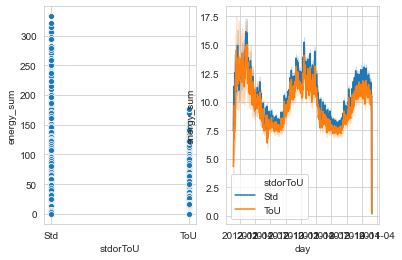

In [28]:
plt.subplot(1,2,1)
sns.set_style('whitegrid')
figsize = (30,5)
sns.scatterplot(data = energy_acorn_time, x = 'stdorToU', y = 'energy_sum', sizes = "coherence")

plt.subplot(1,2,2)
sns.set_style('whitegrid')
figsize = (30,5)
sns.lineplot(data = energy_acorn_time, x = 'day', y = 'energy_sum', hue = 'stdorToU', sizes = "coherence")

 It's obvious that customers on a standard tariff use more electricity than Time of Use customers, and the company can focus there efforts and resources appropriately

# Visualization based on time#

In [29]:
##Clean the energy by day data set leaving only the time stamps and energy sum

energy_by_day_clone = energy_by_day.drop(['LCLid'], axis = 1)
energy_by_day_clone = energy_by_day_clone.groupby(['day'])['energy_mean'].sum().reset_index()


day1_temp = pd.DatetimeIndex(energy_by_day_clone['day'])
day1_hold = pd.Series(day1_temp)
#day1_hold
day_plot = energy_by_day_clone.drop(['day'], axis = 1)
day_plot = day_plot.join(day1_hold)
day_plot


,energy_mean,day
0,6.952692,2011-11-23
1,8.536480,2011-11-24
2,9.499781,2011-11-25
3,10.267707,2011-11-26
4,10.850805,2011-11-27
...,...,...
824,10.411403,2014-02-24
825,10.294997,2014-02-25
826,10.202945,2014-02-26
827,10.356350,2014-02-27


In [30]:
##create columns for the month, year and date elements
day_plot['month']=day_plot['day'].apply(lambda x: x.strftime('%m'))
day_plot['week_days']=day_plot['day'].apply(lambda x: x.strftime('%A'))
day_plot['year']=day_plot['day'].apply(lambda x: x.strftime('%y'))

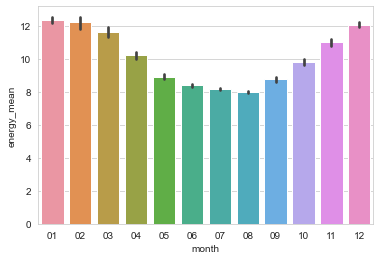

In [31]:
##Plot the monthly distribution of data
sns.barplot(x = 'month', y = 'energy_mean', data = day_plot)

It can be seen that electricity usage is highest at the beginning and end of the year, reducing over time towards the middle. This is an important insight for planning and scheduling. Weather may also be a factor in this monthly variation and it would be interesting to see how this would play out with Nigerian electricity usage data

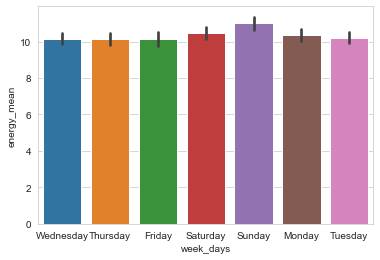

In [32]:
###Plot daily data distribution
sns.barplot(x = 'week_days', y = 'energy_mean', data = day_plot)

Electricity usage is higher over the weekends perhaps due to more people being at home.

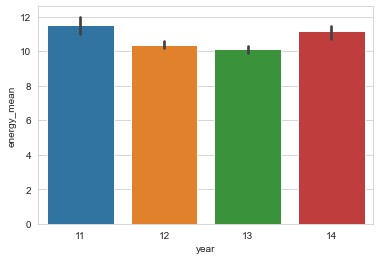

In [34]:
###plot annual data distribution
sns.barplot(x = 'year', y = 'energy_mean', data = day_plot)

There might be some unexplained reason for the initial drop and rise in electricity consumption

# Visualization Based on Weather

In [35]:
#Import the weather data
weather = pd.read_csv("/Users/user/Documents/Stutern Task_files/Final_Power_Project/Project_Submission_Ayooluwa/smart_meters_data/weather_daily_darksky.csv")
weather = weather[['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase','time']]

weather['time'] = pd.to_datetime(weather['time'])
weather['time'] = pd.to_datetime(weather['time'], format ='%Y%m%d').dt.date  #Convert to date time format


energy_weather = pd.merge(energy_by_day, weather, left_on = 'day', right_on = 'time', how = 'inner') #Merge with energy by day dataframe to give time data
energy_weather.head()

,energy_sum,LCLid,energy_mean,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,...,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,time
0,90.385000,13,6.952692,10.36,229,6.29,0.36,2.04,1027.12,10.36,...,0.93,6.56,10.36,1.0,8.24,3.81,10.36,2.18,0.94,2011-11-23
1,213.412000,25,8.536480,12.93,204,8.56,0.41,4.04,1027.22,12.93,...,0.89,7.30,12.93,1.0,9.71,8.56,12.93,7.01,0.97,2011-11-24
2,303.993000,32,9.499781,13.03,243,7.24,0.48,5.02,1024.47,12.27,...,0.79,4.69,13.03,1.0,7.01,7.46,12.27,4.84,0.01,2011-11-25
3,420.976000,41,10.267707,12.96,237,6.96,0.44,5.75,1025.80,12.96,...,0.81,11.59,12.96,1.0,11.59,7.01,12.96,4.69,0.05,2011-11-26
4,444.883001,41,10.850805,13.54,256,5.76,0.42,5.48,1021.11,13.54,...,0.72,1.31,13.54,1.0,1.31,4.47,13.54,2.94,0.08,2011-11-27


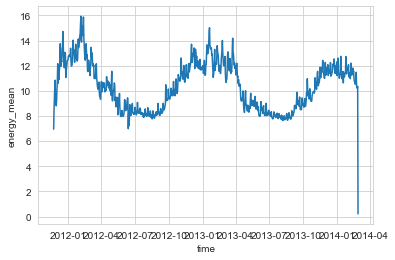

In [36]:
#Plot the energy usage over time
sns.set_style('whitegrid')
figsize = (30,5)
sns.lineplot(data = energy_weather, x = 'time', y = 'energy_mean', sizes = "coherence")

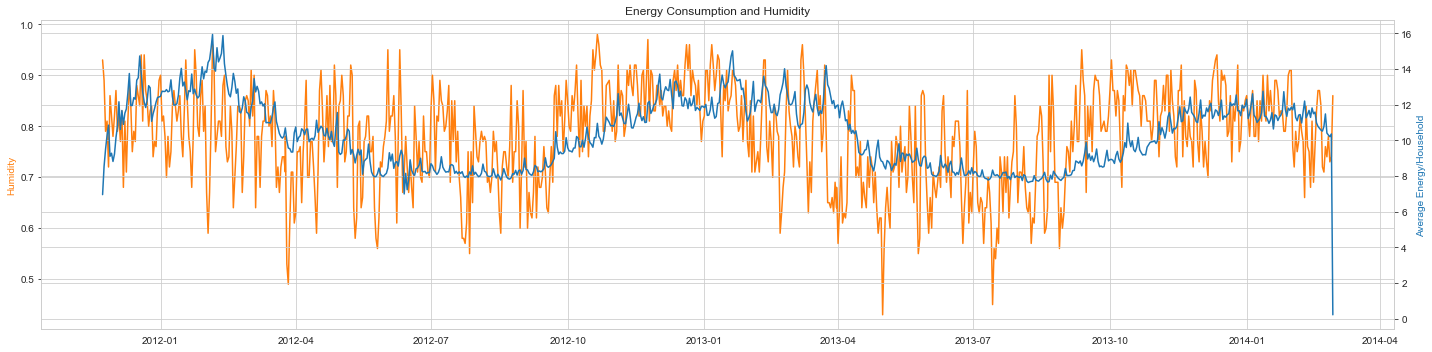

In [37]:
##Plot energy usage against humidity
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(energy_weather.time, energy_weather.humidity, color = 'tab:orange')
ax1.set_ylabel('Humidity',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(energy_weather['time'],energy_weather['energy_mean'],color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Humidity')
fig.tight_layout()
plt.show()

Apparently, energy usage is directly proportional to humidity, meaning people probably have to heat up their homes when it gets cold

No handles with labels found to put in legend.
No handles with labels found to put in legend.


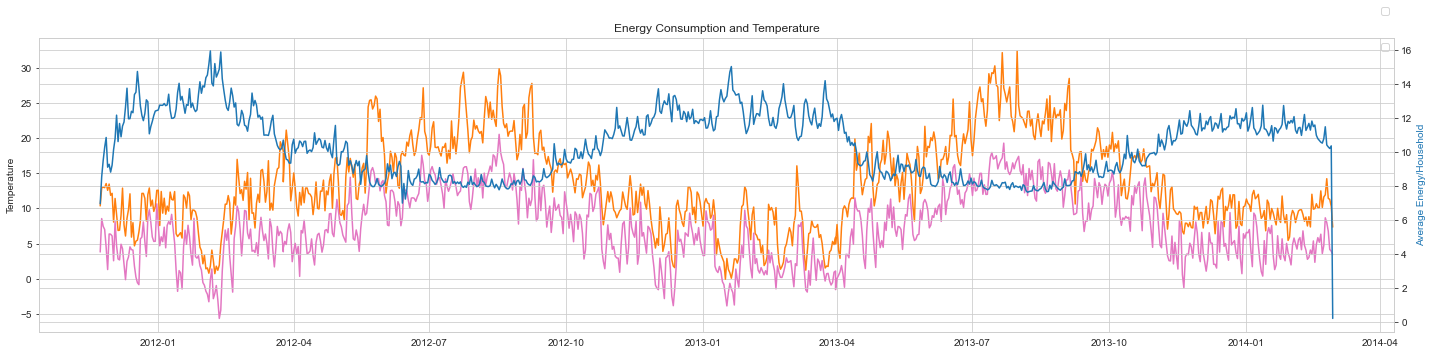

In [40]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(energy_weather.time, energy_weather.temperatureMax, color = 'tab:orange')
ax1.plot(energy_weather.time, energy_weather.temperatureMin, color = 'tab:pink')
ax1.set_ylabel('Temperature')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(energy_weather.time,energy_weather.energy_mean,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Temperature')
fig.tight_layout()
plt.show()

As expected, there's a negative correlation between weather temperature and electricity consumption. Again, it would be interesting to see this play out on Nigerian data

# Time Series Analysis

Functions: These are helper functions that will help in plotting and analyzing trend and other time series properties

In [41]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Description: This is a measure of model accuracy that measures how far predictions are from actual data
    args:
    y_true- The actual electricity data
    y_pred- Predicted/Forecasted data
    output:
    MAPE
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



def plot_moving_average(series, window, plot_intervals = True, scale = 1.96):
    """
    Description: Returns a graph of smoothened data using a moving average
    args:
    series- Data to be smoothened
    window- period over which smoothening is carried out
    scale- Range between upper and lower intervals
    output:
    Plot of smoothened data
    """
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize = (17,8))
    plt.title('Moving average')
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label = 'Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
        
    plt.plot(series[window:], label = 'Actual values')
    plt.legend(loc = 'best')
    plt.grid(True)
    
def exponential_smoothing(series, alpha):
    """
    Description: Returns an exponentially smoothed data
    args:
    series- Data to be smoothened
    alpha- Exponential smoothening weight
    output:
    Data that has been smoothed over exponentially
    """
    result = [series.iloc[0]]
    for n in range(1, len(series)):
        result.append(alpha*series.iloc[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    """
    Description: Returns a graph of exponentially smoothened data using a moving average
    args:
    series- Data to be smoothened
    alphas- collection of weights to loop through to see degree of smoothing
    output:
    Plot of smoothened data
    """
    plt.figure(figsize = (17,8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label = "Alpha{}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc = "best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)
    
    
def tsplot(y, lags = None, figsize = (12,7), style = 'bmh'):
    """
    Description: Returns a time series plot of the data
    args:
    y- Data to be smoothened
    lags- Intervals at which data is repeated
    output:
    Time series plot of data
    """    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    with plt.style.context(style = 'bmh'):
        fig = plt.figure(figsize = figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan = 2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax = ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis\n Dickey-Fuller: p = {0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags = lags, ax = acf_ax)
        smt.graphics.plot_pacf(y, lags = lags, ax = pacf_ax)
        plt.tight_layout()
        

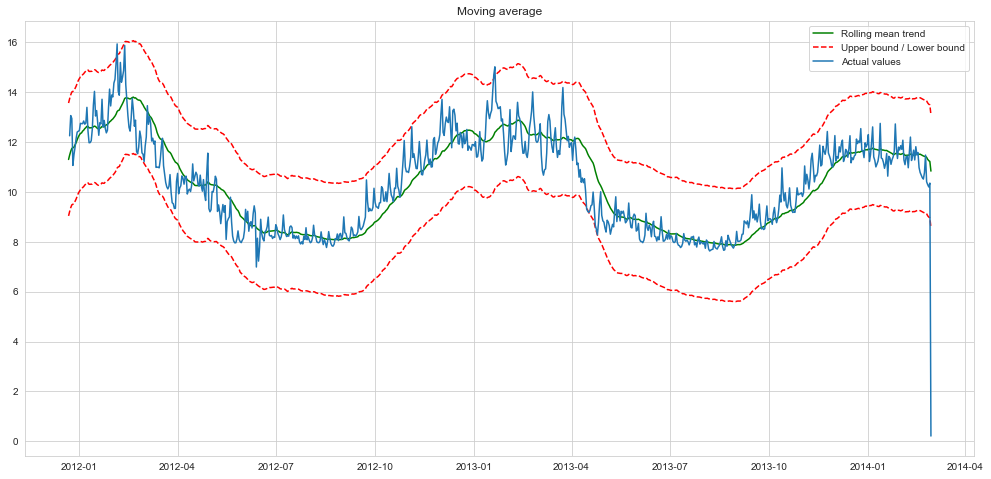

In [42]:
#Plot the moving average over a 30 day (1 month) window
SARIMA_data = energy_by_day['energy_mean']
plot_moving_average(SARIMA_data, 30)

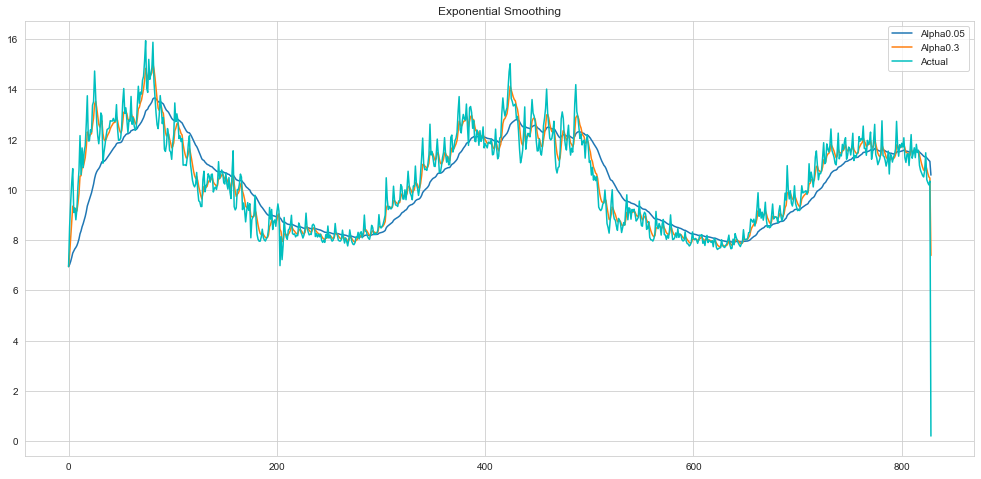

In [43]:
plot_exponential_smoothing(SARIMA_data, [0.05, 0.3]) #plot exponential smoothing trying out weights of 0.05 and 0.3

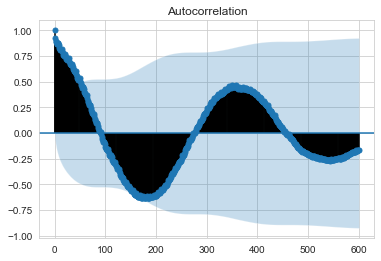

In [54]:
#Autocorrelation plot
plot_acf(SARIMA_data, lags = 600)
plt.show()

C:\Users\user\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\user\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\user\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\user\Anaconda3\lib\site-packages\pandas\plotting\_matplotli

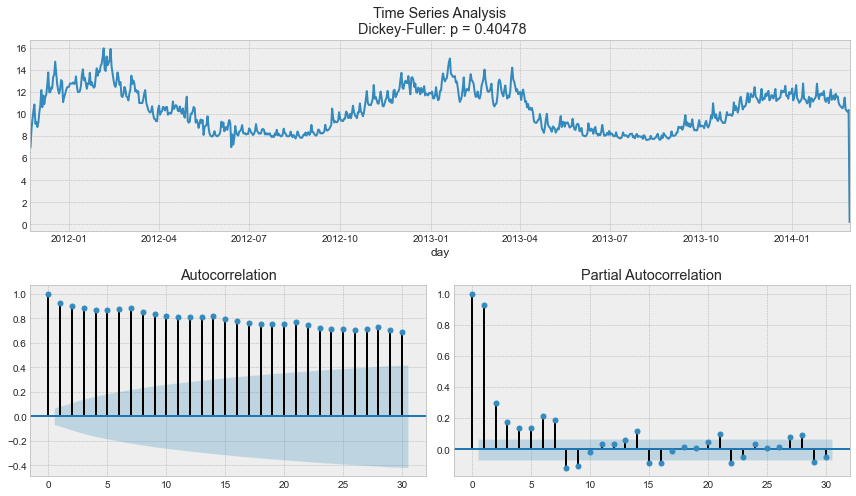

In [55]:
##time series plot calling the tsplot function
tsplot(SARIMA_data, lags = 30)

C:\Users\user\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\user\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\user\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\user\Anaconda3\lib\site-packages\pandas\plotting\_matplotli

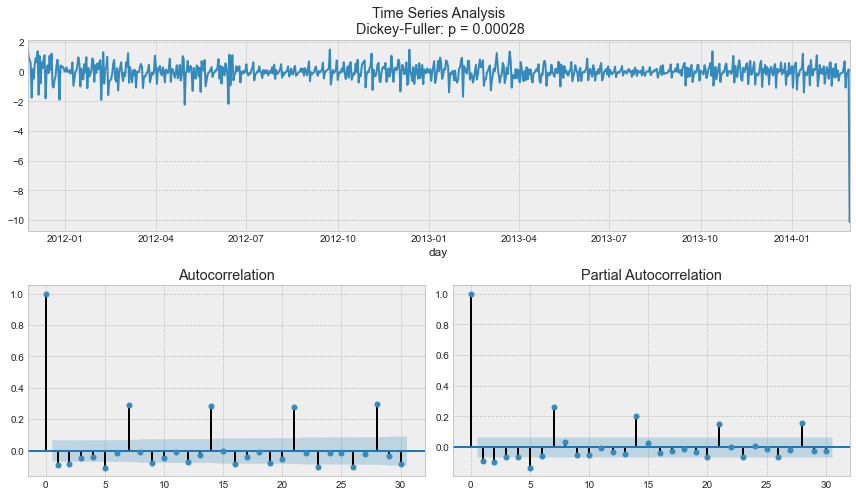

In [56]:
##Introduce stationarity by integrating through the difference
difference = energy_by_day['energy_mean'] - energy_by_day['energy_mean'].shift(1)

tsplot(difference[1:], lags = 30)

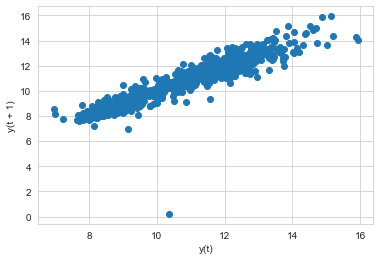

In [57]:
pd.plotting.lag_plot(energy_by_day['energy_mean'])
plt.show()

# Engineering Location Cluster Features to Improve S-ARIMA performance 

In this section, the acorn and location clusters created initially will be aggregated and merged with the the energy_by_day dataframe

In [44]:
def convert_acorn(cols):
    """
    Description: Convert the Acorn_grouped column into numbers
    Args: 
    Col- Column to be converted
    Ouput:
    Numbers 0 to 2
    """
    if cols == 'Affluent':
        return 2
    elif cols == 'Comfortable':
        return 1
    elif cols == 'Adversity':
        return 0
    
energy_acorn_time['acorn_numbers'] = energy_acorn_time['Acorn_grouped'].apply(convert_acorn) #apply the function to create a new column with the numbers

In [45]:
acorn_cluster = energy_acorn_time.groupby('day')['acorn_numbers'].mean() ##Aggregate the cluster numbers by mean
energy_by_day = energy_by_day.merge(acorn_cluster, on = 'day') #merge with the energy_by_day dataframe
energy_by_day.head()

,energy_sum,LCLid,energy_mean,acorn_numbers
day,,,,
2011-11-23,90.385000,13,6.952692,1.153846
2011-11-24,213.412000,25,8.536480,1.240000
2011-11-25,303.993000,32,9.499781,1.250000
2011-11-26,420.976000,41,10.267707,1.243902
2011-11-27,444.883001,41,10.850805,1.243902


In [46]:
LCLid_cluster = energy_acorn_time.groupby('day')['location_cluster'].mean()##Aggregate the location cluster numbers by mean
energy_by_day = energy_by_day.merge(LCLid_cluster, on = 'day')#merge with the energy_by_day dataframe
energy_by_day.head()

,energy_sum,LCLid,energy_mean,acorn_numbers,location_cluster
day,,,,,
2011-11-23,90.385000,13,6.952692,1.153846,0.615385
2011-11-24,213.412000,25,8.536480,1.240000,0.520000
2011-11-25,303.993000,32,9.499781,1.250000,0.500000
2011-11-26,420.976000,41,10.267707,1.243902,0.487805
2011-11-27,444.883001,41,10.850805,1.243902,0.487805


# Build Seasonal ARIMA predictive model

In [47]:
#Split into train and test 
model_data = energy_by_day

train = model_data.iloc[0:(len(model_data)-30)]
test = model_data.iloc[len(train):(len(model_data)-1)]

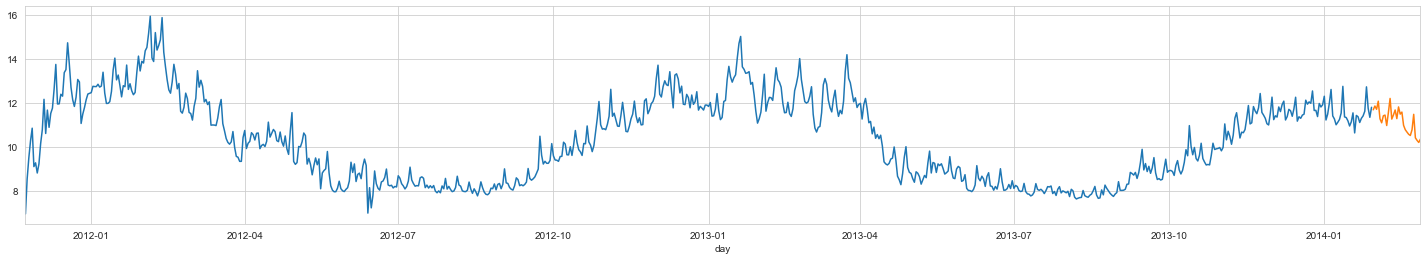

In [48]:
##Plot the train and test data
train['energy_mean'].plot(figsize=(25,4))
test['energy_mean'].plot(figsize=(25,4))

In [82]:
##Train a Seasonal ARIMA model using location cluster data as exogenous regressors
endog = train['energy_mean']
exog = sm.add_constant(train[['acorn_numbers','location_cluster']])
mod = sm.tsa.statespace.SARIMAX(endog=endog, exog = exog, order =(7,1,1), seasonal_order = (1,1,0,12), trend='c')
model_fit = mod.fit()
model_fit.summary()

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        energy_mean   No. Observations:                  799
Model:             SARIMAX(7, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -627.205
Date:                            Thu, 28 May 2020   AIC                           1282.410
Time:                                    23:06:18   BIC                           1347.747
Sample:                                11-23-2011   HQIC                          1307.531
                                     - 01-29-2014                                         
Covariance Type:                              opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept           -0.0078      0.017     -0.450      0.653      -0.042       0.026
const            -4.013e-06   3.02e+05  -1.33e-11      1.000   -5.92e+05    5.92e+05
acorn_numbers        6.7207      2.446      2.747      0.006       1.926      11.516
location_cluster     3.4544      2.670      1.294      0.196      -1.778       8.687
ar.L1               -0.0365      0.083     -0.438      0.661      -0.200       0.127
ar.L2               -0.1577      0.032     -4.910      0.000      -0.221      -0.095
ar.L3               -0.1268      0.037     -3.429      0.001      -0.199      -0.054
ar.L4               -0.1905      0.037     -5.162      0.000      -0.263      -0.118
ar.L5               -0.1369      0.040     -3.427      0.001      -0.215      -0.059
ar.L6               -0.0172      0.036     -0.477      0.633      -0.088       0.054
ar.L7                0.3760      0.029     13.063      0.000       0.320       0.432
ma.L1               -0.1352      0.089     -1.518      0.129      -0.310       0.039
ar.S.L12            -0.5121      0.033    -15.650      0.000      -0.576      -0.448
sigma2               0.2866      0.012     24.023      0.000       0.263       0.310
===================================================================================
Ljung-Box (Q):                      248.15   Jarque-Bera (JB):                52.44
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.24e+14. Standard errors may be unstable.
"""

In [83]:
##Make Forecasts
predict = model_fit.predict(start = len(train), end = len(train)+len(test)-1, exog = sm.add_constant(test[['acorn_numbers', 'location_cluster']]))
test['predicted'] = predict.values
test.tail(5)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,energy_sum,LCLid,energy_mean,acorn_numbers,location_cluster,predicted,residual
day,,,,,,,
2014-02-23,57379.092995,4998,11.480411,1.055499,0.399798,11.344982,0.133733
2014-02-24,51994.547004,4994,10.411403,1.055960,0.399192,10.515913,0.106422
2014-02-25,51423.508001,4995,10.294997,1.056150,0.399111,11.147431,0.854662
2014-02-26,50943.305995,4993,10.202945,1.056162,0.399394,11.649066,1.448134
2014-02-27,51678.185998,4990,10.356350,1.055803,0.399515,11.243659,0.888928


In [84]:
##Compare the forecast with actual test data to evaluate performance

test['residual'] = abs(test['energy_mean']-test['predicted'])
MAE = test['residual'].sum()/len(test)
MAPE = (abs(test['residual'])/test['energy_mean']).sum()*100/len(test)
print("MAE:", MAE)
print("MAPE:", MAPE)

MAE: 0.5697116827535283
MAPE: 5.178251163444732


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


It was observed that the choice of exogenous regressor has an effect on model performance.


For a similar solution available at https://www.kaggle.com/rheajgurung/energy-consumption-forecast Weather and holidays were used for clustering and the error values below were gotten
MAE: 0.5853190227226445
MAPE: 5.237822685938685

In this case, the acorn numbers and location cluster were used instead and they all showed lower errors as shown below:
No exog: 
MAE: 0.5785645868202025
MAPE: 5.267211869052448
    
location_cluster alone: 
MAE: 0.5786497675005764
MAPE: 5.267966829606153

arcon_numbers alone: 
MAE: 0.5704207270766022
MAPE: 5.185873083761427    
    
arcon_numbers and location_cluster: 
MAE: 0.5697116827535283
MAPE: 5.178251163444732
    


# Facebook Prophet Predictive Model

This is another predictive model to try out on the dataset

In [86]:
##Fb prophet requires that the data be put in a format where the date time is represented as ds and the data as y
energy_by_day_FBP = energy_by_day.reset_index()
energy_by_day_FBP = energy_by_day_FBP[['day', 'energy_mean']]
energy_by_day_FBP.columns = ['ds','y']
energy_by_day_FBP.head()

,ds,y
0,2011-11-23,6.952692
1,2011-11-24,8.536480
2,2011-11-25,9.499781
3,2011-11-26,10.267707
4,2011-11-27,10.850805


In [87]:
def compare_forecast(historical, forecast):
    """
    Description: Create a dataframe that shows the forecasted values as well as the actual values
    
    args: 
    historical- actual values
    forecast- forecasted values
    
    output: dataframe containing maximum, minimum, forecasts, and actual data
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

def compute_errors(dataset, prediction_size):
    """
    Description: Calculate error between actual and forecasted values
    
    args: 
    dataset- actual values
    prediction_size- number of values or period over which prediction is made
    
    output: MAPE and MAE
    """
    
    dataset = dataset.copy()
    
    dataset['e'] = dataset['y'] - dataset['yhat']
    dataset['p'] = 100 * dataset['e'] / dataset['y']
    
    predicted_part = dataset[-prediction_size:]
    
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [101]:
##train an instance of FbProphet
prediction_size = 30
training_set = energy_by_day_FBP[:-prediction_size]
fb_instance = Prophet()#daily=_seasonality=True)
fb_instance.fit(training_set)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [102]:
##Make predictions 
future_df = fb_instance.make_future_dataframe(periods = prediction_size)
forecast = fb_instance.predict(future_df)

In [103]:
#Compare and generate error values
comparison_df = compare_forecast(energy_by_day_FBP, forecast)
comparison_df.head()
for err_name, err_value in compute_errors(comparison_df, prediction_size).items():
    print(err_name, err_value)

MAPE 169.66739959091305
MAE 0.7489090359244136


It appears there's a trade off between MAPE and MAE depending on the prediction size. The line of code below tries out various values of prediction size

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


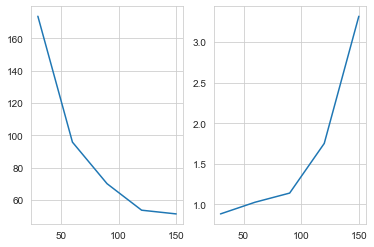

In [104]:
prediction_range = list()
error_list = list()
error_list_MAPE = list()
error_list_MAE = list()
for prediction_size in range(30,180,30):
    prediction_range.append(prediction_size)
    training_set = energy_by_day_FBP[:-prediction_size]
    fb_instance = Prophet(daily_seasonality=True)
    fb_instance.fit(training_set)
    future_df = fb_instance.make_future_dataframe(periods = prediction_size)
    forecast = fb_instance.predict(future_df)
    comparison_df = compare_forecast(energy_by_day_FBP, forecast)
    for err_name, err_value in compute_errors(comparison_df, prediction_size).items():
        error_list.append(err_value)
for i in range(len(error_list)):
    if i%2 == 0:
        error_list_MAPE.append(error_list[i])
    else:
        error_list_MAE.append(error_list[i])
        
plt.subplot(1,2,1)
plt.plot(prediction_range, error_list_MAPE)
plt.subplot(1,2,2)
plt.plot(prediction_range, error_list_MAE)

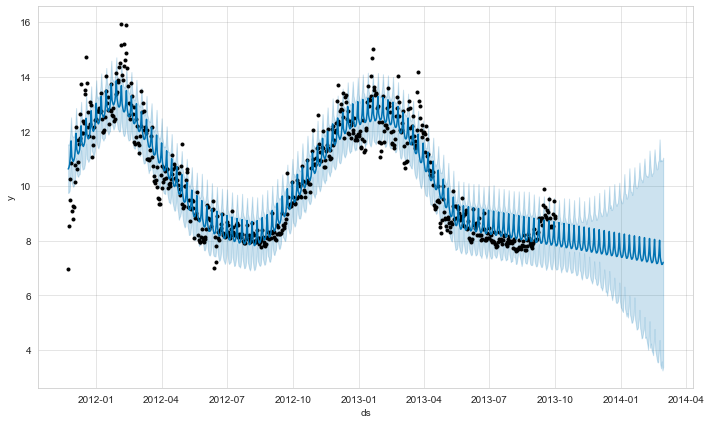

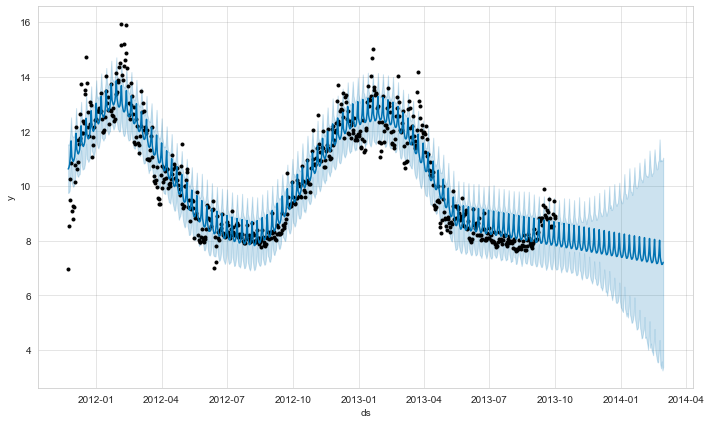

In [105]:
fb_instance.plot(forecast)

Perhaps some work needs to be done in learning to tune the Fb prophet predictor, but for now, the SARIMA model is the better choice